In [22]:
import torch
import torchaudio
import torchaudio.functional
import torchaudio.transforms as T
import IPython.display as ipd

print(torch.__version__)
print(torchaudio.__version__)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torch.nn as nn
import torch.nn.functional
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize
import numpy as np
from functools import partial
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.2.0+cu121
2.2.0+cu121
cuda


In [23]:
class SubsetSC(SPEECHCOMMANDS):
    """
    A class representing a subset of the Speech Commands dataset.

    Args:
        subset (str, optional): The subset to load. Can be one of "validation", "testing", or "training". Defaults to None.
        url (str, optional): The URL to download the dataset from. Defaults to "speech_commands_v0.01".

    Attributes:
        _walker (list): A list of file paths representing the subset.

    """

    def __init__(self, subset: str = None, url="speech_commands_v0.01"):
        super().__init__("./", url=url, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [
                    os.path.normpath(os.path.join(self._path, line.strip()))
                    for line in fileobj
                ]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [24]:
def load_bg_noise(path):
    bg_noise_path = os.path.join(path, "_background_noise_")
    bg_noise_files = os.listdir(bg_noise_path)
    bg_noise_data = []

    for filename in bg_noise_files:
        if filename.endswith(".wav"):
            filepath = os.path.join(bg_noise_path, filename)
            waveform, sample_rate = torchaudio.load(filepath)
            speaker_id, _ = os.path.splitext(filename)
            utterance_number = 0
            bg_noise_data.append(
                (
                    waveform,
                    sample_rate,
                    "_background_noise_",
                    speaker_id,
                    utterance_number,
                )
            )

    return bg_noise_data


path = "./SpeechCommands/speech_commands_v0.01/"
bg_noise_set = load_bg_noise(path)

In [25]:
print("length of train_set: ", len(train_set))
print("length of test_set: ", len(test_set))
print("length of valid_set: ", len(valid_set))
print("length of bg_noise_set: ", len(bg_noise_set))

length of train_set:  51088
length of test_set:  6835
length of valid_set:  6798
length of bg_noise_set:  6


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


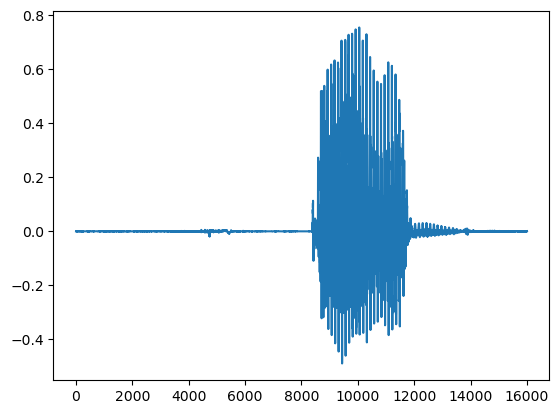

In [26]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

In [27]:
waveform, sample_rate, label, speaker_id, utterance_number = bg_noise_set[2]
ipd.Audio(waveform.numpy(), rate=16000)

In [28]:
w_t, _, _, _, _ = train_set[0]

# Make sure the background noise waveform is the same length as the input waveform
if waveform.size(1) < w_t.size(1):
    waveform = torch.nn.functional.pad(waveform, (0, w_t.size(1) - waveform.size(1)))
elif waveform.size(1) > w_t.size(1):
    waveform = waveform[:, : w_t.size(1)]
# Mix the background noise with the inputw_t, you can adjust the level to control the loudness of the background noise
w_t += waveform * 0.3

ipd.Audio(w_t.numpy(), rate=16000)
# plt.plot(w_t.t().numpy())

Let’s find the list of labels available in the dataset.

In [29]:
# words = sorted(list(set(datapoint[2] for datapoint in test_set))) # Get the words spoken in the dataset
words = [
    "bed",
    "bird",
    "cat",
    "dog",
    "down",
    "eight",
    "five",
    "four",
    "happy",
    "house",
    "left",
    "marvin",
    "nine",
    "no",
    "go",
    "off",
    "on",
    "one",
    "right",
    "seven",
    "sheila",
    "six",
    "stop",
    "three",
    "tree",
    "two",
    "up",
    "wow",
    "yes",
    "zero",
]

We are encoding each word using its index in the list of labels.

In [30]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(words.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return words[index]


# Test
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(28) --> yes


In [31]:
# extraction des features mfcc

n_fft = 1024
n_mels = 40
n_mfcc = 40
hop_length = int(0.04 * 16000)  # 40 ms en échantillons
win_length = int(0.03 * 16000)  # 20 ms en échantillons
sample_rate = 16000

# MFCC transform object
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "win_length": win_length,
        "mel_scale": "htk",
    },
).to(device)


# Fonction pour l'augmentation des données
def data_augmentation(waveform, parameters):
    # Time shift perturbation
    if parameters["time_shift"][0]:
        shift_ms = random.uniform(
            parameters["time_shift"][1][0], parameters["time_shift"][1][1]
        )
        shift_samples = int(sample_rate * shift_ms / 1000)
        waveform = torch.roll(waveform, shifts=shift_samples, dims=-1)

    # Apply SpecAugment
    # 2 continuous time masks of size [0, 25] time steps
    if parameters["time_mask"][0]:
        time_masking = T.TimeMasking(
            time_mask_param=random.randint(
                parameters["time_mask"][1][0], parameters["time_mask"][1][1]
            )
        ).to(device)
        waveform = time_masking(waveform)
        waveform = time_masking(waveform)  # Apply twice for 2 continuous time masks

    if parameters["freq_mask"][0]:
        # 2 continuous frequency masks of size [0, 15] frequency bands
        frequency_masking = T.FrequencyMasking(
            freq_mask_param=random.randint(
                parameters["freq_mask"][1][0], parameters["freq_mask"][1][1]
            )
        ).to(device)
        waveform = frequency_masking(waveform)
        waveform = frequency_masking(
            waveform
        )  # Apply twice for 2 continuous frequency masks

    # Add background noise
    if parameters["bg_noise"][0]:
        bg_waveform, _, _, _, _ = random.choice(bg_noise_set)
        bg_waveform = bg_waveform.to(device)

        if bg_waveform.size(1) < waveform.size(1):
            bg_waveform = torch.nn.functional.pad(
                bg_waveform, (0, waveform.size(1) - bg_waveform.size(1))
            )
        elif bg_waveform.size(1) > waveform.size(1):
            bg_waveform = bg_waveform[:, : waveform.size(1)]

        # Ensure both tensors are on the same device

        waveform += bg_waveform * random.uniform(
            parameters["bg_noise"][1][0], parameters["bg_noise"][1][1]
        )

    return waveform

In [55]:
def extract_mfcc(
    batch,
    parameters,
    augment=False,
    augment_type="random",
    type_pad="zero",
    reshape=False,
):

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:

        if waveform.size(1) < 16000:

            # Pad the waveform if it is shorter than 1 second

            waveform = torch.nn.functional.pad(
                waveform, (0, sample_rate - waveform.size(1)), value=0
            )

        elif waveform.size(1) > 16000:

            # Trim the waveform if it is longer than 1 second

            waveform = waveform[:, :16000]

        # Apply data augmentation to the waveform

        waveform = waveform.to(device)

        if augment:

            if augment_type == "duplicate":

                waveformAug = data_augmentation(waveform, parameters)

            elif augment_type == "random":

                # dans 30 % des cas on applique l'augmentation
                waveformAug = (
                    data_augmentation(waveform, parameters)
                    if random.random() <= 0.4
                    else None
                )
            if waveformAug is not None:

                # Apply MFCC transform to the augmented waveform

                waveformAug = mfcc_transform(waveformAug)

                if reshape:

                    waveformAug = waveformAug.reshape(1, -1)

                tensors.append(waveformAug)

                targets += [label_to_index(label)]

        # Apply MFCC transform to the waveform

        waveform = mfcc_transform(waveform)

        if reshape:

            waveform = waveform.reshape(1, -1)

        tensors.append(waveform)

        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor

    tensors = torch.stack(tensors)

    targets = torch.stack(targets)

    if reshape:

        tensors = tensors.squeeze(1)

    return tensors, targets

In [59]:
# implémentation d'un modèle pas très complexe
import copy


class SimpleNeuralNet(nn.Module):
    """
    A simple neural network model for classification tasks.
    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of units in the hidden layer.
        num_classes (int): The number of output classes.
    """

    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNet, self).__init__()
        self.name = "SimpleNeuralNet"
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Forward pass of the neural network.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            torch.Tensor: The output tensor.
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# # Fonction d'entraînement
# def train(model, train_loader, criterion, optimizer):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(
#             device
#         )  # Charger les données sur le GPU
#         output = model(data)  # Prédiction du modèle
#         loss = criterion(output, target)  # Calcul de la perte
#         optimizer.zero_grad()  # Remettre à zéro les gradients
#         loss.backward()  # Calcul des gradients
#         optimizer.step()  # Mise à jour des poids


# Fonction d'entraînement
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    len_train_loader = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(
            device
        )  # Charger les données sur le GPU
        len_train_loader += len(data)
        output = model(data)  # Prédiction du modèle
        loss = criterion(output, target)  # Calcul de la perte
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        optimizer.zero_grad()  # Remettre à zéro les gradients
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids
    return total_loss / len_train_loader, correct / len_train_loader


# Fonction d'évaluation
# def validation(model, validation_loader, criterion, best_accuracy, best_model, epoch):
#     model.eval()
#     correct = 0
#     len_validation_loader = 0
#     with torch.no_grad():
#         for data, target in validation_loader:
#             data, target = data.to(device), target.to(device)
#             len_validation_loader += len(data)
#             output = model(data)
#             # test_loss += criterion(output, target).item()  # sum up batch loss
#             pred = output.argmax(
#                 dim=1, keepdim=True
#             )  # get the index of the max log-probability
#             correct += (
#                 pred.eq(target.view_as(pred)).sum().item()
#             )  # Number of correct predictions
#     print("len_validation_loader: ", len(validation_loader.dataset))
#     print("len_validation_loader: ", len_validation_loader)
#     accuracy = correct / len_validation_loader
#     print("epoch: ", epoch + 1, "accuracy: ", accuracy)

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         return copy.deepcopy(model), best_accuracy
#     return best_model, best_accuracy


def validation(model, validation_loader, criterion, best_accuracy, best_model, epoch):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += (
                pred.eq(target.view_as(pred)).sum().item()
            )  # Number of correct predictions
    accuracy = correct / len(validation_loader.dataset)
    print("epoch: ", epoch + 1, "accuracy: ", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = copy.deepcopy(model)
    return (
        total_loss / len(validation_loader.dataset),
        accuracy,
        best_model,
        best_accuracy,
    )


# Fonction de test
def test(model, test_loader, proba=False):
    model = model.to(device)
    model.eval()  # Mettre le modèle en mode évaluation
    predictions = torch.tensor([], device=device)
    targets = torch.tensor([], device=device)
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            if proba:  # Si on veut les probabilités des classes
                pred = torch.nn.functional.softmax(output, dim=1)
            else:  # Sinon, on prend la classe avec la probabilité maximale
                pred = output.argmax(dim=1, keepdim=True)
            predictions = torch.cat((predictions, pred), dim=0)
            targets = torch.cat((targets, target), dim=0)
    return predictions.cpu().numpy(), targets.cpu().numpy()

In [68]:
def global_function(
    model=None,
    optimizer=None,
    criterion=None,
    batch=256,
    augment_type="random",
    parameters=None,
    augment=False,
    num_epochs=10,
    reshape=False,
    plot=True,
):

    batch_size = (
        batch // 2 if augment and augment_type == "" else batch
    )  # Batch size for training
    num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

    extract_mfcc_train = partial(
        extract_mfcc,
        parameters=parameters,
        augment=augment,
        augment_type=augment_type,
        reshape=reshape,
    )

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=extract_mfcc_train,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    extract_mfcc_valid = partial(
        extract_mfcc, parameters=parameters, reshape=reshape, augment=False
    )

    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        collate_fn=extract_mfcc_valid,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    # Training function
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    best_accuracy = 0
    best_model = None

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
        valid_loss, valid_accuracy, best_model, best_accuracy = validation(
            model, valid_loader, criterion, best_accuracy, best_model, epoch
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    if plot:
        epochs = range(1, num_epochs + 1)

        plt.figure(figsize=(14, 7))  # Change la taille de la figure

        plt.subplot(1, 2, 1)
        plt.plot(
            epochs, train_accuracies, "r-", label="Training acc"
        )  # Change le style et la couleur de la courbe
        plt.plot(
            epochs, valid_accuracies, "g-", label="Validation acc"
        )  # Change le style et la couleur de la courbe
        plt.title("Training and validation accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(
            epochs, train_losses, "r-", label="Training loss"
        )  # Change le style et la couleur de la courbe
        plt.plot(
            epochs, valid_losses, "g-", label="Validation loss"
        )  # Change le style et la couleur de la courbe
        plt.title("Training and validation loss")
        plt.legend()

        plt.show()
    return best_model

In [29]:
input_size = (sample_rate // hop_length + 1) * n_mfcc
model = SimpleNeuralNet(input_size=input_size, hidden_size=256, num_classes=30).to(
    device
)
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [True, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.1, 0.2]],  # Add background noise
}

# Entraînement du modèle
best_model = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    num_epochs=10,
    reshape=True,
)

 10%|█         | 1/10 [01:14<11:07, 74.16s/it]

epoch:  1 accuracy:  0.6384230656075316


 20%|██        | 2/10 [02:27<09:48, 73.62s/it]

epoch:  2 accuracy:  0.7272727272727273


 30%|███       | 3/10 [03:46<08:53, 76.22s/it]

epoch:  3 accuracy:  0.7628714327743454


 40%|████      | 4/10 [05:03<07:38, 76.43s/it]

epoch:  4 accuracy:  0.7784642541924095


 50%|█████     | 5/10 [06:19<06:21, 76.38s/it]

epoch:  5 accuracy:  0.7946454839658723


 60%|██████    | 6/10 [07:32<05:01, 75.27s/it]

epoch:  6 accuracy:  0.7990585466313621


 70%|███████   | 7/10 [08:44<03:42, 74.01s/it]

epoch:  7 accuracy:  0.8089143865842895


 80%|████████  | 8/10 [10:03<02:31, 75.62s/it]

epoch:  8 accuracy:  0.8117093262724331


 90%|█████████ | 9/10 [11:25<01:17, 77.73s/it]

epoch:  9 accuracy:  0.7931744630773757


100%|██████████| 10/10 [12:41<00:00, 76.19s/it]

epoch:  10 accuracy:  0.7990585466313621


100%|██████████| 27/27 [00:07<00:00,  3.74it/s]


Test Accuracy:  0.7038771031455743
Test Classification Report:
              precision    recall  f1-score   support

         bed       0.57      0.73      0.64       176
        bird       0.69      0.81      0.75       158
         cat       0.55      0.80      0.66       166
         dog       0.55      0.63      0.59       180
        down       0.65      0.68      0.67       253
       eight       0.72      0.74      0.73       257
        five       0.62      0.69      0.65       271
        four       0.79      0.73      0.76       253
          go       0.62      0.46      0.53       251
       happy       0.77      0.86      0.81       180
       house       0.82      0.83      0.83       150
        left       0.63      0.69      0.66       267
      marvin       0.83      0.60      0.70       162
        nine       0.68      0.65      0.66       259
          no       0.58      0.50      0.54       252
         off       0.77      0.68      0.73       262
          on      

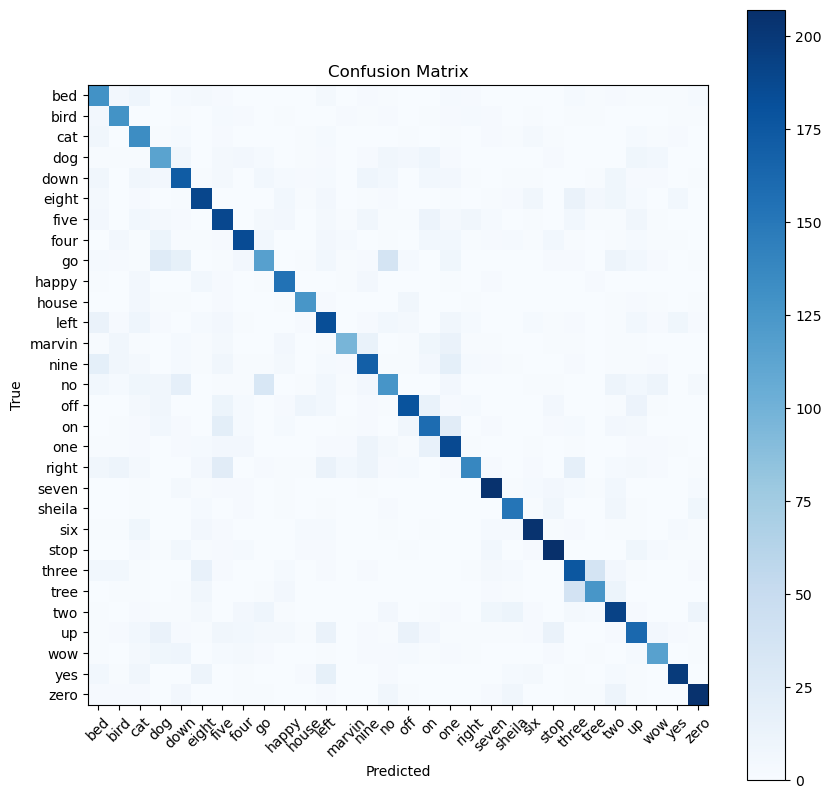

In [33]:
# TEST DU MODELE
# Extraction des features MFCC
extract_mfcc_test = partial(
    extract_mfcc, parameters=parameters, augment=False, reshape=True
)

num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_test,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions, targets = test(best_model, test_loader)
print("Test Accuracy: ", accuracy_score(targets, predictions))


# Afficher les performances
print("Test Classification Report:")
print(classification_report(targets, predictions, target_names=words))

# Matrice de confusion
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Utiliser les labels pour les ticks
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)

plt.show()

### Time shift 

In [12]:
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}
input_size = (sample_rate // hop_length + 1) * n_mfcc
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(
    device
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_shift = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)

 10%|█         | 1/10 [07:25<1:06:49, 445.53s/it]

epoch:  1 accuracy:  0.6459252721388644


 20%|██        | 2/10 [13:44<54:09, 406.25s/it]  

epoch:  2 accuracy:  0.7202118270079435


 30%|███       | 3/10 [16:18<33:57, 291.05s/it]

epoch:  3 accuracy:  0.7481612238893792


 40%|████      | 4/10 [18:31<22:53, 228.93s/it]

epoch:  4 accuracy:  0.757428655486908


 50%|█████     | 5/10 [20:54<16:28, 197.62s/it]

epoch:  5 accuracy:  0.7627243306854957


 60%|██████    | 6/10 [23:07<11:43, 175.93s/it]

epoch:  6 accuracy:  0.7562518387761106


 70%|███████   | 7/10 [25:20<08:04, 161.61s/it]

epoch:  7 accuracy:  0.7700794351279788


 80%|████████  | 8/10 [27:38<05:08, 154.24s/it]

epoch:  8 accuracy:  0.7696381288614298


 90%|█████████ | 9/10 [29:54<02:28, 148.62s/it]

epoch:  9 accuracy:  0.767431597528685


100%|██████████| 10/10 [32:09<00:00, 193.00s/it]

epoch:  10 accuracy:  0.7725801706384231


In [15]:
predictions_shift, targets_shift = test(best_model_shift, test_loader)
print("Test Accuracy: ", accuracy_score(targets_shift, predictions_shift))

100%|██████████| 27/27 [00:46<00:00,  1.71s/it]

Test Accuracy:  0.7528895391367959


### TIME_MASKING

In [66]:
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(
    device
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_TM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:20<30:04, 200.46s/it]

epoch:  1 accuracy:  0.6478375992939099


 20%|██        | 2/10 [05:19<20:20, 152.58s/it]

epoch:  2 accuracy:  0.7215357458075905


 30%|███       | 3/10 [07:19<16:02, 137.52s/it]

epoch:  3 accuracy:  0.7481612238893792


 40%|████      | 4/10 [09:19<13:04, 130.74s/it]

epoch:  4 accuracy:  0.744777875845837


 50%|█████     | 5/10 [11:16<10:29, 125.89s/it]

epoch:  5 accuracy:  0.7480141218005296


 60%|██████    | 6/10 [13:13<08:11, 122.86s/it]

epoch:  6 accuracy:  0.764342453662842


 70%|███████   | 7/10 [15:13<06:05, 121.72s/it]

epoch:  7 accuracy:  0.7628714327743454


 80%|████████  | 8/10 [17:12<04:02, 121.03s/it]

epoch:  8 accuracy:  0.7606649014416005


 90%|█████████ | 9/10 [19:10<02:00, 120.17s/it]

epoch:  9 accuracy:  0.7693439246837305


100%|██████████| 10/10 [21:09<00:00, 126.91s/it]

epoch:  10 accuracy:  0.7616946160635482


In [67]:
predictions_TM, targets_TM = test(best_model_TM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_TM, predictions_TM))

100%|██████████| 27/27 [00:38<00:00,  1.43s/it]

Test Accuracy:  0.7489392831016826


### FREQUENCY_MASKING

In [68]:
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(
    device
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_FM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)

 10%|█         | 1/10 [01:59<17:55, 119.55s/it]

epoch:  1 accuracy:  0.6425419240953222


 20%|██        | 2/10 [04:00<16:04, 120.56s/it]

epoch:  2 accuracy:  0.7077081494557222


 30%|███       | 3/10 [06:01<14:04, 120.62s/it]

epoch:  3 accuracy:  0.7377169755810532


 40%|████      | 4/10 [08:03<12:07, 121.20s/it]

epoch:  4 accuracy:  0.7559576345984113


 50%|█████     | 5/10 [10:06<10:08, 121.73s/it]

epoch:  5 accuracy:  0.7594880847308032


 60%|██████    | 6/10 [12:07<08:06, 121.51s/it]

epoch:  6 accuracy:  0.7530155928214181


 70%|███████   | 7/10 [14:05<06:01, 120.44s/it]

epoch:  7 accuracy:  0.7616946160635482


 80%|████████  | 8/10 [16:06<04:01, 120.51s/it]

epoch:  8 accuracy:  0.7549279199764637


 90%|█████████ | 9/10 [18:06<02:00, 120.48s/it]

epoch:  9 accuracy:  0.7684613121506325


100%|██████████| 10/10 [20:06<00:00, 120.63s/it]

epoch:  10 accuracy:  0.7624301265077964


In [69]:
predictions_FM, targets_FM = test(best_model_FM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_FM, predictions_FM))

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

Test Accuracy:  0.7442574981711778


### FREQUENCY_MASKING, TIME_MASKING, TIME_SHIFT

In [71]:
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(
    device
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_TFM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)

 10%|█         | 1/10 [02:10<19:37, 130.84s/it]

epoch:  1 accuracy:  0.6145925272138865


 20%|██        | 2/10 [04:58<20:19, 152.46s/it]

epoch:  2 accuracy:  0.7035892909679318


 30%|███       | 3/10 [07:46<18:38, 159.75s/it]

epoch:  3 accuracy:  0.7411003236245954


 40%|████      | 4/10 [10:01<14:59, 149.89s/it]

epoch:  4 accuracy:  0.7469844071785819


 50%|█████     | 5/10 [12:15<12:01, 144.21s/it]

epoch:  5 accuracy:  0.754339511621065


 60%|██████    | 6/10 [14:33<09:28, 142.04s/it]

epoch:  6 accuracy:  0.7522800823771697


 70%|███████   | 7/10 [16:49<06:59, 139.96s/it]

epoch:  7 accuracy:  0.7691968225948809


 80%|████████  | 8/10 [18:59<04:33, 136.93s/it]

epoch:  8 accuracy:  0.7689026184171815


 90%|█████████ | 9/10 [21:45<02:25, 145.95s/it]

epoch:  9 accuracy:  0.7621359223300971


100%|██████████| 10/10 [24:00<00:00, 144.01s/it]

epoch:  10 accuracy:  0.7603706972639012


In [72]:
predictions_TFM, targets_TFM = test(best_model_TFM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_TFM, predictions_TFM))

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]

Test Accuracy:  0.7487929773226042


# Implementation CNN

```markdown
**Architecture**
```	
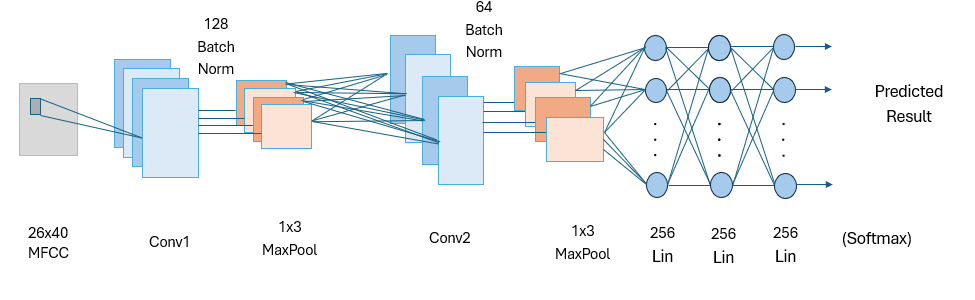

In [35]:
class MFCC_CNN(nn.Module):
    def __init__(self, num_classes=30):
        super(MFCC_CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128, kernel_size=7, padding=1
        )
        self.bn1 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=64, kernel_size=7, padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=500, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.maxpool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        if self.fc1 is None:
            num_features_after_conv = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(
                in_features=num_features_after_conv, out_features=500
            ).to(x.device)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:43<24:27, 163.03s/it]

epoch:  1 accuracy:  0.7668431891732863


 20%|██        | 2/10 [03:56<14:43, 110.38s/it]

epoch:  2 accuracy:  0.8331862312444837


 30%|███       | 3/10 [05:09<10:54, 93.45s/it] 

epoch:  3 accuracy:  0.8581935863489262


 40%|████      | 4/10 [06:21<08:29, 84.94s/it]

epoch:  4 accuracy:  0.8718740806119447


 50%|█████     | 5/10 [07:42<06:56, 83.33s/it]

epoch:  5 accuracy:  0.8811415122094733


 60%|██████    | 6/10 [11:40<09:03, 135.85s/it]

epoch:  6 accuracy:  0.8889379229185055


 70%|███████   | 7/10 [14:40<07:31, 150.49s/it]

epoch:  7 accuracy:  0.8865842894969108


 80%|████████  | 8/10 [15:53<04:11, 125.66s/it]

epoch:  8 accuracy:  0.8909973521624007


 90%|█████████ | 9/10 [17:09<01:50, 110.12s/it]

epoch:  9 accuracy:  0.8932038834951457


100%|██████████| 10/10 [18:23<00:00, 110.36s/it]

epoch:  10 accuracy:  0.9024713150926743


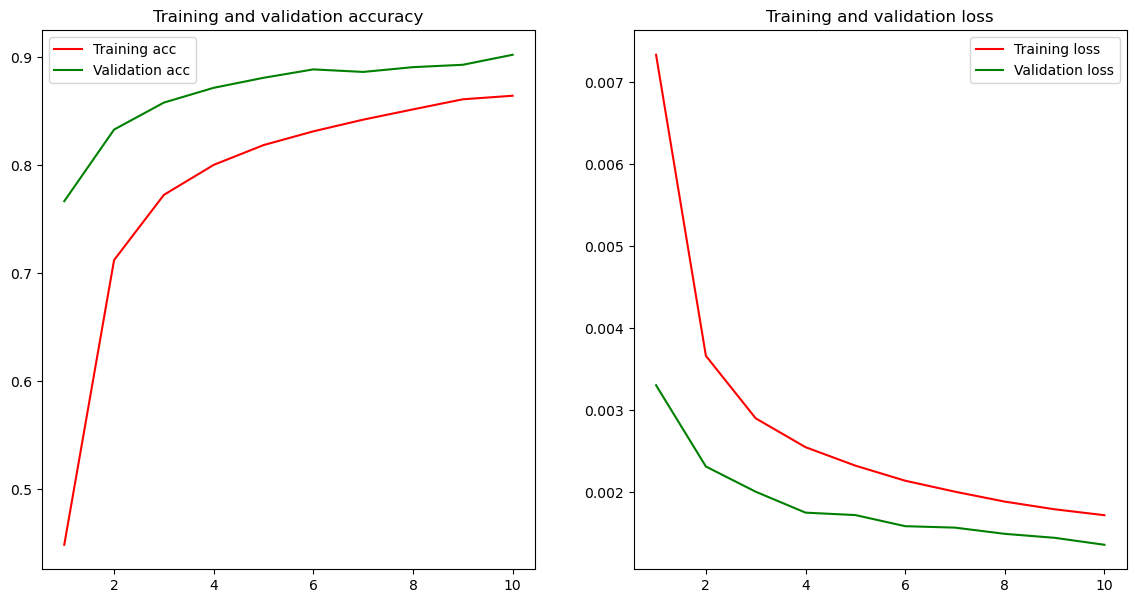

In [36]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking.
    "bg_noise": [False, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    augment_type="duplicate",
    num_epochs=10,
)

In [73]:
num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)
parameters = {
    "time_shift": [True, [-80, 80]],  # Time shift perturbation
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.05, 0.2]],  # Add background noise
}
extract_mfcc_cnn = partial(extract_mfcc, parameters=parameters, augment=False)
extract_mfcc_cnn_aug = partial(extract_mfcc, parameters=parameters, augment=True)


test_loader_cnn = DataLoader(
    test_set,

    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader_cnn_aug = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn_aug,
    num_workers=num_workers,
    pin_memory=pin_memory,
)



predictions_cnn, targets_cnn = test(best_model_cnn, test_loader_cnn)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))

predictions_cnn_, targets_cnn_ = test(best_model_cnn, test_loader_cnn_aug)
print(
    "Test Accuracy avec aug sur les données de test: ",
    accuracy_score(targets_cnn_, predictions_cnn_),
)

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test Accuracy:  0.8945135332845647


100%|██████████| 27/27 [00:14<00:00,  1.85it/s]

Test Accuracy avec aug sur les données de test:  0.8519259103346664


In [20]:
parameters = {
    "time_shift": [True, [-80, 80]],  # Time shift perturbation
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.1, 0.3]],  # Add background noise
}

extract_mfcc_train = partial(
    extract_mfcc,
    parameters=parameters,
    augment=True,
)
test_loader_cnn = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    collate_fn=extract_mfcc_train,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions_cnn, targets_cnn = test(best_model_cnn, test_loader_cnn)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))

100%|██████████| 27/27 [00:34<00:00,  1.26s/it]

Test Accuracy:  0.5038039502560351


### Time shift

In [78]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [-80, 80]],  # Time shift perturbation
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [False, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:25<21:48, 145.35s/it]

epoch:  1 accuracy:  0.8303912915563401


 20%|██        | 2/10 [04:43<18:50, 141.30s/it]

epoch:  2 accuracy:  0.863047955280965


 30%|███       | 3/10 [07:03<16:23, 140.46s/it]

epoch:  3 accuracy:  0.8833480435422183


 40%|████      | 4/10 [09:21<13:57, 139.60s/it]

epoch:  4 accuracy:  0.8792291850544278


 50%|█████     | 5/10 [11:39<11:35, 139.14s/it]

epoch:  5 accuracy:  0.890850250073551


 60%|██████    | 6/10 [13:56<09:13, 138.33s/it]

epoch:  6 accuracy:  0.8820241247425713


 70%|███████   | 7/10 [16:15<06:55, 138.66s/it]

epoch:  7 accuracy:  0.8940864960282436


 80%|████████  | 8/10 [18:36<04:38, 139.35s/it]

epoch:  8 accuracy:  0.8880553103854075


 90%|█████████ | 9/10 [20:54<02:18, 138.97s/it]

epoch:  9 accuracy:  0.8918799646954987


100%|██████████| 10/10 [23:12<00:00, 139.29s/it]

epoch:  10 accuracy:  0.8961459252721389


In [80]:
predictions_cnn_TS, targets_cnn = test(best_model_cnn_TS, test_loader_cnn)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn_TS))

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]

Test Accuracy:  0.8936356986100951


### TIME_MASKING

In [27]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [False, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

 10%|█         | 1/10 [07:25<1:06:45, 445.03s/it]

epoch:  1 accuracy:  0.7964107090320682


 20%|██        | 2/10 [16:03<1:05:05, 488.14s/it]

epoch:  2 accuracy:  0.8255369226243012


 30%|███       | 3/10 [23:54<56:01, 480.20s/it]  

epoch:  3 accuracy:  0.8428949691085613


 40%|████      | 4/10 [30:10<43:54, 439.15s/it]

epoch:  4 accuracy:  0.862165342747867


 50%|█████     | 5/10 [36:25<34:40, 416.20s/it]

epoch:  5 accuracy:  0.8615769343924684


 60%|██████    | 6/10 [42:42<26:50, 402.64s/it]

epoch:  6 accuracy:  0.8583406884377758


 70%|███████   | 7/10 [48:59<19:43, 394.35s/it]

epoch:  7 accuracy:  0.8684907325684025


 80%|████████  | 8/10 [55:22<13:01, 390.69s/it]

epoch:  8 accuracy:  0.8649602824360106


 90%|█████████ | 9/10 [1:01:48<06:29, 389.17s/it]

epoch:  9 accuracy:  0.8714327743453957


100%|██████████| 10/10 [1:08:08<00:00, 408.90s/it]

epoch:  10 accuracy:  0.874374816122389


In [18]:
extract_mfcc_cnn = partial(extract_mfcc, parameters=parameters, augment=False)
num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)
test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions_cnn_TS, targets_cnn = test(best_model_cnn_TS, test_loader)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn_TS))

100%|██████████| 25/25 [00:56<00:00,  2.26s/it]

Test Accuracy:  0.9074542008843968


### FREQUENCY_MASKING

In [30]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
    "bg_noise": [False, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

 10%|█         | 1/10 [03:07<28:11, 187.93s/it]

epoch:  1 accuracy:  0.774786701971168


 20%|██        | 2/10 [08:24<35:06, 263.34s/it]

epoch:  2 accuracy:  0.8386290085319211


 30%|███       | 3/10 [13:00<31:24, 269.25s/it]

epoch:  3 accuracy:  0.8445130920859076


 40%|████      | 4/10 [16:10<23:49, 238.20s/it]

epoch:  4 accuracy:  0.8587819947043248


 50%|█████     | 5/10 [19:17<18:17, 219.42s/it]

epoch:  5 accuracy:  0.870844365989997


 60%|██████    | 6/10 [22:24<13:53, 208.40s/it]

epoch:  6 accuracy:  0.873050897322742


 70%|███████   | 7/10 [25:31<10:05, 201.69s/it]

epoch:  7 accuracy:  0.8615769343924684


 80%|████████  | 8/10 [28:37<06:33, 196.52s/it]

epoch:  8 accuracy:  0.8702559576345984


 90%|█████████ | 9/10 [31:42<03:12, 192.98s/it]

epoch:  9 accuracy:  0.8727566931450427


100%|██████████| 10/10 [34:49<00:00, 209.00s/it]

epoch:  10 accuracy:  0.863047955280965


In [31]:
predictions_cnn_TS, targets_cnn = test(best_model_cnn_TS, test_loader)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn_TS))

100%|██████████| 27/27 [00:35<00:00,  1.31s/it]

Test Accuracy:  0.8596927578639356


#### Background noise

In [89]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_bg = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:42<24:23, 162.66s/it]

epoch:  1 accuracy:  0.8064136510738452


 20%|██        | 2/10 [05:24<21:39, 162.46s/it]

epoch:  2 accuracy:  0.8681965283907032


 30%|███       | 3/10 [08:06<18:55, 162.25s/it]

epoch:  3 accuracy:  0.8768755516328332


 40%|████      | 4/10 [10:47<16:09, 161.61s/it]

epoch:  4 accuracy:  0.8814357163871727


 50%|█████     | 5/10 [13:28<13:27, 161.43s/it]

epoch:  5 accuracy:  0.8896734333627537


 60%|██████    | 6/10 [16:05<10:39, 160.00s/it]

epoch:  6 accuracy:  0.8802588996763754


 70%|███████   | 7/10 [18:45<07:59, 159.90s/it]

epoch:  7 accuracy:  0.8857016769638129


 80%|████████  | 8/10 [21:25<05:19, 159.76s/it]

epoch:  8 accuracy:  0.8992350691379818


 90%|█████████ | 9/10 [24:04<02:39, 159.78s/it]

epoch:  9 accuracy:  0.9015887025595763


100%|██████████| 10/10 [26:44<00:00, 160.48s/it]

epoch:  10 accuracy:  0.8876140041188585


In [90]:
predictions_cnn_bg, targets_cnn = test(best_model_cnn_bg, test_loader_cnn)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn_bg))

100%|██████████| 27/27 [00:10<00:00,  2.65it/s]

Test Accuracy:  0.8920263350402341


### FREQUENCY_MASKING, TIME_MASKING, TIME_SHIFT

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:16<11:27, 76.44s/it]

epoch:  1 accuracy:  0.8968814357163871


 20%|██        | 2/10 [02:34<10:17, 77.14s/it]

epoch:  2 accuracy:  0.8965872315386878


 30%|███       | 3/10 [03:51<08:59, 77.06s/it]

epoch:  3 accuracy:  0.8967343336275375


 40%|████      | 4/10 [05:06<07:38, 76.40s/it]

epoch:  4 accuracy:  0.8970285378052368


 50%|█████     | 5/10 [15:35<22:57, 275.59s/it]

epoch:  5 accuracy:  0.8971756398940864


 60%|██████    | 6/10 [16:50<13:49, 207.39s/it]

epoch:  6 accuracy:  0.8964401294498382


 70%|███████   | 7/10 [18:01<08:08, 162.97s/it]

epoch:  7 accuracy:  0.8970285378052368


 80%|████████  | 8/10 [19:13<04:28, 134.04s/it]

epoch:  8 accuracy:  0.8965872315386878


 90%|█████████ | 9/10 [20:25<01:54, 114.67s/it]

epoch:  9 accuracy:  0.8965872315386878


100%|██████████| 10/10 [21:38<00:00, 129.85s/it]

epoch:  10 accuracy:  0.8958517210944396


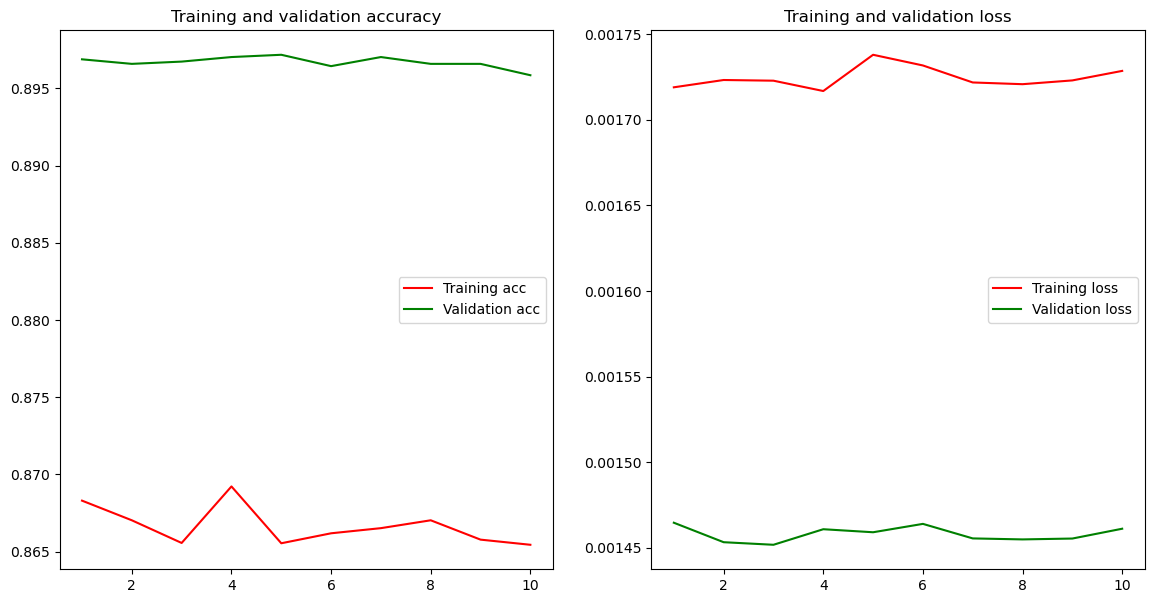

In [78]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [-80, 80]],  # Time shift perturbation
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.05, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=best_model_cnn_TS,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    augment_type="random",
    num_epochs=10,
)

In [77]:
num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)
parameters = {
    "time_shift": [True, [-80, 80]],  # Time shift perturbation
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.05, 0.2]],  # Add background noise
}
extract_mfcc_cnn = partial(extract_mfcc, parameters=parameters, augment=False)
extract_mfcc_cnn_aug = partial(extract_mfcc, parameters=parameters, augment=True)

test_loader_cnn = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader_cnn_aug = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn_aug,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


predictions_cnn, targets_cnn = test(best_model_cnn_TS, test_loader_cnn)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))

predictions_cnn_, targets_cnn_ = test(best_model_cnn_TS, test_loader_cnn_aug)
print(
    "Test Accuracy avec aug sur les données de test: ",
    accuracy_score(targets_cnn_, predictions_cnn_),
)

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test Accuracy:  0.891441111923921


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]

Test Accuracy avec aug sur les données de test:  0.857742782152231


#### Il faut continuer les tests ...

In [94]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [-50, 50]],  # Time shift perturbation
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
    "bg_noise": [True, [0.1, 0.2]],  # Add background noise
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [06:05<54:45, 365.01s/it]

epoch:  1 accuracy:  0.8237716975581053


 20%|██        | 2/10 [08:48<32:52, 246.61s/it]

epoch:  2 accuracy:  0.8571638717269785


 30%|███       | 3/10 [11:31<24:19, 208.43s/it]

epoch:  3 accuracy:  0.8842306560753163


 40%|████      | 4/10 [14:10<18:53, 188.87s/it]

epoch:  4 accuracy:  0.8865842894969108


 50%|█████     | 5/10 [16:50<14:51, 178.35s/it]

epoch:  5 accuracy:  0.8865842894969108


 60%|██████    | 6/10 [19:28<11:26, 171.57s/it]

epoch:  6 accuracy:  0.8977640482494852


 70%|███████   | 7/10 [22:06<08:21, 167.06s/it]

epoch:  7 accuracy:  0.8979111503383348


 80%|████████  | 8/10 [24:44<05:28, 164.12s/it]

epoch:  8 accuracy:  0.894380700205943


 90%|█████████ | 9/10 [27:24<02:42, 162.92s/it]

epoch:  9 accuracy:  0.8951162106501912


100%|██████████| 10/10 [30:05<00:00, 180.59s/it]

epoch:  10 accuracy:  0.8961459252721389


100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


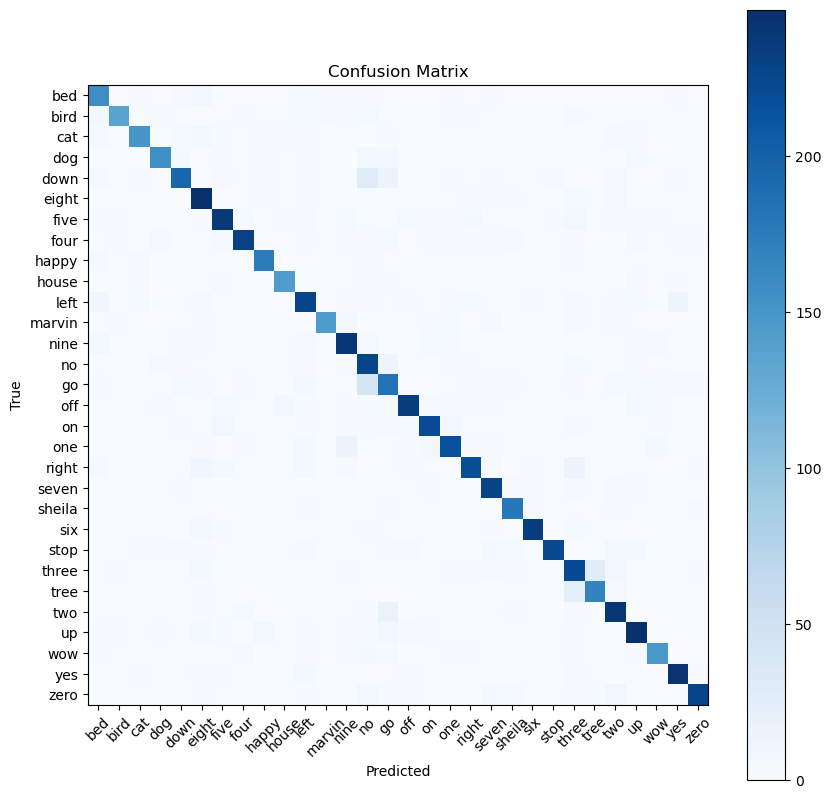

Test Classification Report:
              precision    recall  f1-score   support

         bed       0.83      0.90      0.86       176
        bird       0.96      0.86      0.91       158
         cat       0.93      0.90      0.91       166
         dog       0.95      0.87      0.91       180
        down       0.91      0.77      0.84       253
       eight       0.85      0.96      0.90       257
        five       0.91      0.88      0.89       271
        four       0.95      0.91      0.93       253
       happy       0.96      0.97      0.96       180
       house       0.94      0.95      0.94       150
        left       0.85      0.85      0.85       267
      marvin       0.98      0.89      0.93       162
        nine       0.86      0.93      0.89       259
          no       0.69      0.90      0.78       252
          go       0.72      0.73      0.73       251
         off       0.94      0.89      0.92       262
          on       0.94      0.89      0.91       246

In [71]:
pred, y = test(model=best_model_cnn_TS, test_loader=test_loader_cnn)

# matrice de confusion
cm = confusion_matrix(y, pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Utiliser les labels pour les ticks
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)

plt.show()

# Afficher les performances
print("Test Classification Report:")
print(classification_report(y, pred, target_names=words))

100%|██████████| 27/27 [00:10<00:00,  2.49it/s]


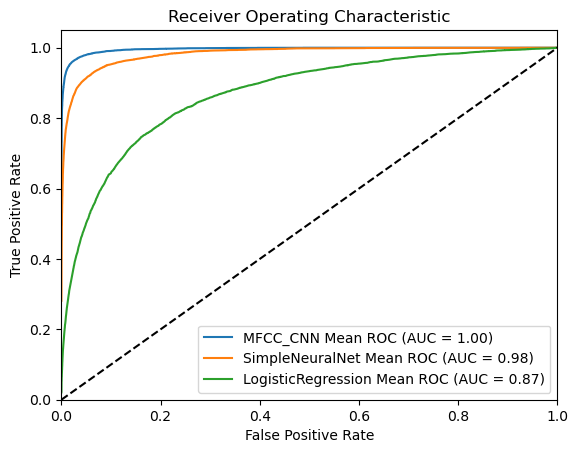

In [44]:
def plot_roc_curve(models, test_loaders):
    plt.figure()
    for model, test_loader in zip(models, test_loaders):
        scores, y_test = test(model, test_loader, proba=True)
        y_test = label_binarize(y_test, classes=np.arange(30))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(30):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(30)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(30):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 30

        mean_auc = auc(all_fpr, mean_tpr)
        plt.plot(
            all_fpr,
            mean_tpr,
            label=f"{model.__class__.__name__} Mean ROC (AUC = {mean_auc:.2f})",
        )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(
    [best_model_cnn_TS, best_model_shift, best_model_lr],
    [test_loader_cnn, test_loader, test_loader],
)

In [42]:
# Logistic regression


class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.name = "LogisticRegression"
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)


input_size = (sample_rate // hop_length + 1) * n_mfcc
model = LogisticRegression(input_size=input_size, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
best_model_lr = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    num_epochs=10,
    reshape=True,
)

 10%|█         | 1/10 [06:09<55:29, 369.96s/it]

epoch:  1 accuracy:  0.3350985583995293


 20%|██        | 2/10 [08:12<29:53, 224.25s/it]

epoch:  2 accuracy:  0.34936746101794647


 30%|███       | 3/10 [09:45<19:11, 164.55s/it]

epoch:  3 accuracy:  0.35333921741688734


 40%|████      | 4/10 [11:56<15:07, 151.27s/it]

epoch:  4 accuracy:  0.35201529861724035


 50%|█████     | 5/10 [13:32<10:56, 131.36s/it]

epoch:  5 accuracy:  0.3373050897322742


 60%|██████    | 6/10 [14:56<07:40, 115.24s/it]

epoch:  6 accuracy:  0.3323036187113857


 70%|███████   | 7/10 [16:25<05:20, 106.70s/it]

epoch:  7 accuracy:  0.33318623124448365


 80%|████████  | 8/10 [17:56<03:23, 101.65s/it]

epoch:  8 accuracy:  0.35583995292733156


 90%|█████████ | 9/10 [19:29<01:39, 99.02s/it] 

epoch:  9 accuracy:  0.35333921741688734


100%|██████████| 10/10 [20:56<00:00, 125.61s/it]

epoch:  10 accuracy:  0.35157399235069137


In [43]:
predictions_lr, targets_lr = test(best_model_lr, test_loader)
print("Test Accuracy: ", accuracy_score(targets_lr, predictions_lr))

100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

Test Accuracy:  0.3281638624725677
